# Activity 2-1: Simulating the Ising model

## The Ising model

As a simple model of a ferromagnetic material, we can consider a set of spins arranged on a lattice. The energy of a pair of spins will be lower if they are aligned in the same direction. To make our analysis simple, we'll assume that only **nearest neighbor** spins are coupled together. Spins that aren't nearest neighbors could also interact, but these interactions will be much weaker due to the greater distance between them.

Mathematically, we can write the energy of a configuration $\underline{\sigma}=\{\sigma_1, \sigma_2, \ldots, \sigma_N\}$ of spins $\sigma_i\in\{-1,1\}$ in a one-dimensional lattice as

$$ 
E(\underline{\sigma}) = -\sum_{i=1}^{N-1} J \sigma_i\,\sigma_{i+1}\,.
$$

The coupling $J$ tells us how strong the interaction is between two neighboring spins.

## Monte Carlo simulation

If we want to measure properties of an Ising model with $N$, such as the average magnetization of a particular spin, we won't be able to average over all configurations of the system unless $N$ is very small (or unless we are very clever see the [Wikipedia page](https://en.wikipedia.org/wiki/Ising_model) for much more information)!

However, we can use a **Monte Carlo simulation** to get information about the Ising model even if we can't average over all configurations exactly. To do this, we'll start in a particular configuration of the system. Then, we'll randomly change the configuration in a way that satisfies **detailed balance**. There are many possible ways to do this, but the following rule (known as the [Metropolis rule](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm)) is one of the simplest:

- Choose a spin at random  
- Compute the difference between the energy we would have if the chosen spin was "flipped" from $+1$ to $-1$, or vice versa, and the energy of the current configuration, which we call $\Delta E$    
- If $\Delta E<0$, so that the new energy is less than the current one, then the spin is always flipped  
- Otherwise, the spin is flipped with probability $p = e^{-\beta \Delta E}$, where $\beta = 1 / T$ and $T$ is the temperature

## 1. Building the simulation step by step

Monte Carlo simulation of a large system usually can't be performed in just a few lines of code. We'll make our work simpler by writing down the things that our program needs to do, and then writing a function to execute each of those things.

In general, the steps are:

1. Prepare an initial configuration of the system  
2. Iterate Monte Carlo  
    a. Randomly choose a spin to flip  
    b. Compute the change in energy if the spin flips  
    c. Draw a random number and choose whether or not the spin flips  
    d. Update and save the configuration  
3. Analyze and visualize the results  

### 1.a. Set up the initial configuration

Let's call our configuration `spins`. We'll choose a system size of $N=20$. We'll also try starting with a random configuration of spins instead of a fixed order. 

Fill in the code below to define a function, `initialize_spins`, that returns a list of spins with random orientations (that is, each spin is assigned $+1$ or $-1$ at random with equal probabilities).

In [0]:
import numpy as np
import numpy.random as rng

# Define the system size and initialize random number generator

N = 20
r = rng.RandomState(0)

# Write the function to produce a random initial configuration

def initialize_spins():
    """ 
    Returns a configuration of N spins, where each spin is assigned
        +1 with probability 1/2, and
        -1 with probability 1/2
    """
    
    spins = []
    for i in range(N):
      spins.append(np.random.choice([1, -1]))
        # < Your code here! >
        # Add a new entry to `spins` that is either +1 or -1 with probability 1/2
        # Hint: you could do this using r.rand() combined with if/else statements,
        # or you could use the numpy.random.choice function (more on this later)
            
    # Return the result
    
    return spins

### 1.b. Test `initialize_spins`

Execute the code block below to test your function. If it works properly, you should see a set of $20$ numbers that are equal to $\pm 1$, with about an even number of positive and negative spins (though there will be a substantial amount of variation!).

In [16]:
# Get the initial configuration of spins

N = 20
spins = initialize_spins()

# And print the results

print('The length of the configuration is {}'.format(len(spins)))
print('There are {} + spins and {} - spins'.format(np.sum(np.array(spins)==1), np.sum(np.array(spins)==-1)))
print('The configuration is:')
print(spins)

The length of the configuration is 20
There are 7 + spins and 13 - spins
The configuration is:
[1, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, -1, -1]


### 1.c. Choose a random spin

Next, during each step of the MC algorithm we need to choose a spin at random, which we will attempt to flip. To do this, we'll use a function `numpy.random.choice`, which selects a random element from a list. By default, the probability of each element is equal. We can also pass this function a number $N$ instead of a list to randomly choose a number between $0$ and $N-1$. For more information, search this function in the `NumPy` docs or use `help(np.random.choice)`.

Execute the code below to define a function, `choose_spin`, that will select a spin index uniformly at random from the lattice.

In [0]:
def choose_spin():
    """
    Choose spin indices at random. 
    We assume that the lattice size N has already been defined.
    """
    
    # Return a random index between 0 and N-1
    
    return np.random.choice(N)

### 1.d. Test `choose_spin`

Execute the code block below to test your function. If it works properly, you should see a nearly uniform distribution over the range from $\left[0, 1, \ldots, N-1\right]$.

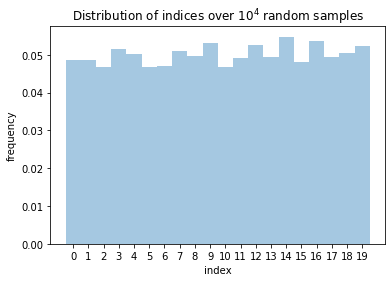

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

indices = []

# Randomly sample a lot of indices

for k in range(10**4):
    indices.append(choose_spin())

# And check their distribution

sns.distplot(indices, bins=np.arange(0, N+1, 1), norm_hist=True,
             kde=False, hist_kws={'align': 'left'})
plt.title(r'Distribution of indices over $10^4$ random samples')
plt.xlabel('index')
plt.ylabel('frequency')
plt.xticks(range(N));

### 1.e. Compute the change energy of a configuration

The most important step we need to complete is to compute how the energy would change if we flipped a selected spin $\sigma_{i}$ to $-\sigma_{i}$. For example, if $\sigma_{i}=-1$, how would the energy change if we set $\sigma_{i}=1$ instead?

To do this, we can write a function to compute the energy of each configuration and take the difference in the energy of the two configurations (with and without the spin flipped). Fill in the code below to define a function `compute_E` to compute the energy of a configuration.

**Note: you could also compute the difference in energy $\Delta E$ directly! If you're up for more of a challenge, instead of writing code to compute the energy of a configuration, try writing a function that computes $\Delta E$.**

In [0]:
# Define the function to compute the energy of a configuration

def compute_E(spins):
    """ This function computes the energy of a spin configuration assuming J=1. """
    
    energy = 0
    
    # Fill in code here to add up the energy
    for i in range(len(spins)-1):
      energy -= spins[i]*spins[i+1]

    return energy

### 1.f. Test `compute_E`

Execute the code block below to test your function. We'll prepare two special configurations and check to see if the computed $\Delta E$ is the same as what we expect. If you don't get the expected result, return to 1.e. above to revise your function.

In [21]:
# Define the test configuration

N = 20
spins = [1 for i in range(N)] # this is called a list comprehension!
spins_flipped = [i for i in spins] # this line creates a copy of `spins`


# And test compute_E

spins_flipped[-1] = -1
dE = compute_E(spins_flipped) - compute_E(spins)
if dE == 2:
    print('Success! Got delta_E = %.2f, expected delta_E = %.2f' % (dE, 2))
else:
    print('Test unsuccessful! Got delta_E = %.2f, expected delta_E = %.2f' % (dE, 2))

spins[-1] = -1
spins_flipped[-2] = -1
dE = compute_E(spins_flipped) - compute_E(spins)
if dE == 0:
    print('Success! Got delta_E = %.2f, expected delta_E = %.2f' % (dE, 0))
else:
    print('Test unsuccessful! Got delta_E = %.2f, expected delta_E = %.2f' % (dE, 0))

Success! Got delta_E = 2.00, expected delta_E = 2.00
Success! Got delta_E = 0.00, expected delta_E = 0.00


## 2. Code the simulation

Now we've defined all the helper functions that we need to run our Monte Carlo simulation. Recall that our steps were

1. Prepare an initial configuration of the system  
2. Iterate Monte Carlo  
    a. Randomly choose a spin to flip  
    b. Compute the change in energy if the spin flips  
    c. Draw a random number and choose whether or not the spin flips  
    d. Update and save the configuration  
3. Analyze and visualize the results  

To choose whether or not the spin flips, we'll follow the [Metropolis rule](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm),

$$
P({\rm flip}) = \begin{cases} 
1 &\text{if }\Delta E < 0\\
e^{-\Delta E/T} &\text{if } \Delta E > 0
\end{cases} \,.
$$


Fill in the code below to execute these steps. We will put our Monte Carlo simulation code inside a function `MC_simulate` so that we can reuse it easily. Analysis and visualization will be in part 3 below. 

In [0]:
import numpy as np
import numpy.random as rng


def MC_simulate(T, n_steps):
    """
    This function runs a Monte Carlo simulation of the 1D Ising model
    and returns an array of n_steps configurations of the system.
    We assume that the coupling strength J is equal to 1.
    The temperature T and number of Monte Carlo steps n_steps are
    passed as parameters.
    """

    # Define global variables

    N = 20        # system size
    configs = []  # container for configurations

    # Randomize the starting configuration

    spins = initialize_spins()

    # Begin MC simulation

    for _step in range(n_steps):

        # Record the current configuration
        # NOTE: we have to create a copy, or all configurations will be one copy of the last one

        configs.append([i for i in spins])
        
        # Choose a random spin `k` to attempt to flip

        k = choose_spin()

        # Compute the change in energy

        # step 1: make a copy of the current spins

        temp_spins = [i for i in spins]
        

        # step 2: change spin k from +1 to -1 (or vice versa) in the copied configuration

        temp_spins[k] = temp_spins[k] * -1
        

        # step 3: compute the change in energy

        delta_E = compute_E(temp_spins) - compute_E(spins)
        

        # Check to see if the spin flips
        # Here we use a new if/else statement `elif`, 
        # which is short for "else if"

        if delta_E < 0:
            spins[k] = spins[k] * -1
        elif rng.rand() < np.exp(-delta_E/T):
            spins[k] = spins[k] * -1

    # Finally, return the stored configurations

    return configs

## 3. Analyze and visualize the results

### 3.a. The Ising model at high temperature

First, let's run a simulation at a temperature of $T=5$. We'll take $10^4$ Monte Carlo steps in our simulation. Execute the code below to gather the simulation data and display it. We'll use some functions from `matplotlib` to make an [animation](https://towardsdatascience.com/how-to-create-animated-graphs-in-python-bb619cc2dec1) so that we can visualize how the configuration of the system changes!

**Note:** animation can be tricky, and the libraries needed to create animations are not as well standardized as other ones we've been using. **If this code fails**, you may be able to troubleshoot the problem (for example, this might require installing a library like `ffmpeg`). However, I've confirmed that this approach does work on Google Colaboratory.

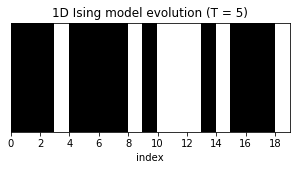

In [9]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Gather the simulation data

configs = np.array(MC_simulate(5, 10000)).reshape((10000, 1, 20))

# Visualize the configurations!

xs, ys = np.meshgrid(range(N), range(1))
fig = plt.figure(figsize=(5, 2))
plt.xlim(0, N-1)
plt.ylim(0, 1)
plt.xticks(range(0, N, 2))
plt.xlabel('index')
plt.title('1D Ising model evolution (T = 5)')

writer = animation.writers['ffmpeg']
writer = writer(fps=20, metadata=dict(artist='Me'))

p = plt.pcolormesh(configs[0], cmap=plt.get_cmap('binary'))
plt.yticks([])

def animate(i):
    p.set_array(configs[i].ravel())
    return p


anim_high = animation.FuncAnimation(
    fig, animate, frames=range(0, 10000, 10), interval=10)
#anim_high.save('T=5.mp4', writer=writer)

### 3.b. Display the animation (high T)

The code above will create and save (if you uncomment the bottom line) an animation of the evolution of the system. Execute the code block below to display the animation in the Jupyter notebook.

In [10]:
HTML(anim_high.to_html5_video())

### 3.c. The Ising model at low temperature

Next, let's run a simulation at a temperature of $T=1$. As before we'll take $10^4$ Monte Carlo steps. 

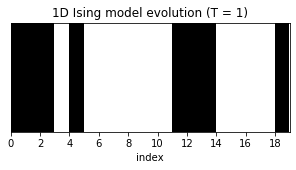

In [11]:
from IPython.display import HTML
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Gather the simulation data

configs = np.array(MC_simulate(1, 10000)).reshape((10000, 1, 20))

# Visualize the configurations!

xs, ys = np.meshgrid(range(N), range(1))
fig = plt.figure(figsize=(5, 2))
plt.xlim(0, N-1)
plt.ylim(0, 1)
plt.xticks(range(0, N, 2))
plt.xlabel('index')
plt.title('1D Ising model evolution (T = 1)')

writer = animation.writers['ffmpeg']
writer = writer(fps=20, metadata=dict(artist='Me'))

p = plt.pcolormesh(configs[0], cmap=plt.get_cmap('binary'))
plt.yticks([])

def animate(i):
    p.set_array(configs[i].ravel())
    return p


anim_low = animation.FuncAnimation(
    fig, animate, frames=range(0, 10000, 10), interval=10)
#anim_low.save('T=1.mp4', writer=writer)

### 3.d. Display the animation (low T)

Execute the code block below to display the evolution of the 1D Ising model at low temperature.

In [12]:
HTML(anim_low.to_html5_video())

### 3.e. Assessing the results

Compare your simulations at high and low temperatures. What differences do you observe? Can you explain the results?

We won't have time to discuss this in the class, but the **2D** Ising model has a [phase transition](https://en.wikipedia.org/wiki/Phase_transition) in between these two temperatures, which occurs at a critical temperature

$$ T_c = \frac{2}{\log\left(1+\sqrt{2}\right)} \approx 2.27\,. $$

The simulation at high temperature is above $T_c$, in the disordered phase, and the simulation at low temperature is in the ordered phase below $T_c$. In **1D** there is no phase transition, but you should observe a clear difference in behavior!